This notebook analyzed the Amazon product reviews for bluebooth headphones, and the intention is to find the suspecious patterns on the products review, together with the grade found on FakeSpot by Mozilla.

There are two main parts on this notebook, the first part on extracting review data from Amazon by Selenium. The second part focus on the analysis on the patterns of the reviews.

In [3]:
from utils.utils import save_pickle, load_pickle

# Part 1 - Data Extraction by Selenium

Please skip this part and move to Part 2 if you are interested on analysis and modeling

In [1]:
from amazon_scraper import AmazonReviewScraper
from selenium.webdriver.common.by import By
import os, json
os.environ["AMAZON_CREDENTIAL"] = "/Users/jinli1/Projects/jing-toy/.vscode/amazon_credential.json"
amazon_credential_path = os.environ["AMAZON_CREDENTIAL"]
with open(amazon_credential_path, "r") as file:
    amazon_credential = json.load(file)

ars = AmazonReviewScraper(amazon_credential["username"], amazon_credential["password"])
ars.sign_in()

{'browserName': 'chrome', 'pageLoadStrategy': <PageLoadStrategy.normal: 'normal'>, 'goog:chromeOptions': {'prefs': {'credentials_enable_service': False, 'profile.password_manager_enabled': False, 'autofill.profile_enabled': False, 'credentials_offer_save_update_password': False, 'password_manager_offer_save_update_password': False, 'password_manager_enable_autosignin': False, 'goog:localPasskeySetting': False}, 'extensions': [], 'args': ['--password-store=basic', '--incognito']}}


True

### Extract the text message on each product review pages on count of ratings and reviews

In [ ]:
page_to_extract = 10
review_rating_dict = ars.find_similar_product_review_rating_counts(page_to_extract)

In [3]:
product_review_count = {}
for url, count_str in review_rating_dict.items():
    product_review_count.setdefault(url, {})
    product_review_count[url]["total_ratings"]=AmazonReviewScraper.extract_ratings_and_reviews(count_str)[0]
    product_review_count[url]["total_reviews"]=AmazonReviewScraper.extract_ratings_and_reviews(count_str)[1]
    product_review_count[url]["review_rating_ratio"] = product_review_count[url]["total_reviews"]/product_review_count[url]["total_ratings"]

<Axes: ylabel='Count'>

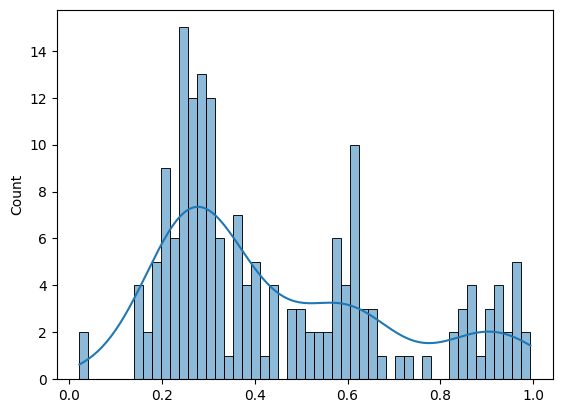

In [5]:
import seaborn as sns
ratios = [p_dict["review_rating_ratio"] for p_dict in product_review_count.values() if p_dict["review_rating_ratio"] < 1]
sns.histplot(ratios, bins=50, kde=True)

### Extract the Fakespot grade for those products

In [ ]:
fakesport_grade = dict()
for product_url in review_rating_dict.keys():
    try:
        fakespot_grade = ars.get_fakespot_grade(product_url)
        fakesport_grade[product_url] = fakespot_grade
        print(fakespot_grade, product_url)
    except:
        continue

In [54]:
grade_product_dict = {}
for url, grade in fakesport_grade.items():
    grade_product_dict.setdefault(grade, [])
    grade_product_dict[grade].append(url)


In [ ]:
# save_pickle(fakesport_grade, "fakesport_grade.pkl")

### Get the product review for all above product

Note: there's a limitation on the number of review we can see from the product review page. So to standarize the review data, we always get the reviews "by recent" and extract all reviews on the page, every product has maximum of 100 reviews (could be less if the acutal number of reviews are less than it)

In [ ]:
product_reviews = {}
for url, grade in fakesport_grade.items():
    ars.driver.get(url)
    ars.driver.find_element(By.ID, "acrCustomerReviewText").click()
    ars.driver.find_element(By.CSS_SELECTOR, "a[data-hook='see-all-reviews-link-foot']").click()
    review_dict = ars.find_all_reviews(ars.driver.current_url, 20)
    product_reviews[url] = review_dict


In [ ]:
# save_pickle(product_reviews, "product_reviews.pkl")

Dictionary product_reviews successfully saved.


# Part 2 - EDA and Analysis
### Generate standard features for reviews

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def preprocess_text_and_get_tokens(text):
    """Preprocesses a given text string."""

    # 1. Lowercasing
    text = text.lower()
    # 2. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 4. Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
     # 6. Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 7. Tokenization
    tokens = word_tokenize(text)
    # 8. Remove Stop Words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # 9. Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens

def extract_text_features(tokens):
    """Extract features from tokenized text."""

    text = " ".join(tokens)
    feature_dict = {}

    # Basic Features
    feature_dict["word_count"] = len(tokens)
    feature_dict["avg_word_len"] = sum(len(word) for word in tokens) / len(tokens) if tokens else 0
    feature_dict["unique_word_count"] = len(set(tokens))

    # Sentiment Features
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    feature_dict["sentiment_pos"] = scores["pos"]
    feature_dict["sentiment_neg"] = scores["neg"]
    feature_dict["sentiment_neu"] = scores["neu"]
    feature_dict["sentiment_comp"] = scores["compound"]

    return feature_dict

In [ ]:
import pandas as pd

# load data
product_reviews = load_pickle("cache/product_reviews")

# generate features for every review and save them in a dictionary
product_features = {}
for product_url, p_dict in product_reviews.items():
    product_features.setdefault(product_url, {})
    for review_id, review_d in p_dict.items():
        # create tokens
        product_features[product_url].setdefault(review_id, {})
        tokens = preprocess_text_and_get_tokens(review_d["review_text"])
        product_features[product_url][review_id]["tokens"] = tokens

        # extract basic features
        feature_dict = extract_text_features(product_features[product_url][review_id]["tokens"])
        product_features[product_url][review_id]["feature_dict"] = feature_dict

        # reconstruct string by token 
        token_string = " ".join([token for token in product_features[product_url][review_id]["tokens"]])
        product_features[product_url][review_id]["token_string"] = token_string

        # create feature list
        feature_list = []
        feature_list.append(review_d["has_image"])
        feature_list.append(review_d["has_video"])
        feature_list.append(review_d["review_rating"])
        feature_list.extend(list(product_features[product_url][review_id]["feature_dict"].values()))
        product_features[product_url][review_id]["features"] = feature_list

# combine the reviews into a dataframe
dfs = []
for product_url, reviews in product_features.items():
    df_product_features = pd.DataFrame({review_id: (d["features"] + [d["token_string"]]) for review_id, d in product_features[product_url].items()}).T
    df_product_features.columns = [f"feature_{n}" for n in range(10)] + ["token_string"]
    df_product_features["product_url"] = product_url
    df_product_features["review_rating_ratio"] = review_rating_dict[product_url]["review_rating_ratio"]
    df_product_features["product_fakespot_grade"] = fakesport_grade[product_url]
    dfs.append(df_product_features)
df_all_product_features = pd.concat(dfs)

# save_pickle(df_all_product_features, "df_all_product_features")

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_35480/1869277840.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [385]:
df_all_product_features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,token_string,product_url,review_rating_ratio,product_fakespot_grade
R30SZV56T07JOV,False,False,4,9,6.111111,7,0.577,0.0,0.423,0.8012,quality sound really good good quality materia...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R2YD8IZAN1L5QV,False,False,1,20,4.5,17,0.0,0.217,0.783,-0.6124,difficult pair pair alexa never got work even ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1SG3KLESASNYO,False,False,4,4,5.5,4,0.516,0.0,0.484,0.4927,price product really good,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R1BRUHA6158TD1,False,False,1,14,5.357143,14,0.326,0.163,0.512,0.5423,product performs 20 ear bud design great idea ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
R3IK00EI1WUVQO,False,False,4,7,5.714286,7,0.406,0.0,0.594,0.6249,great battery life connection volume 100 phone,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R3FRDB5B4OBRUA,False,False,2,48,5.25,42,0.128,0.053,0.819,0.4703,despite use 54 bluetooth chip 142 mm driver so...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R1K92OG4FIP8XR,False,False,5,40,5.975,35,0.507,0.0,0.493,0.9832,absolutely fantastic use driving job great bat...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R3898SHCPYITBL,False,False,5,44,4.568182,41,0.445,0.063,0.493,0.9766,work awesome airpod pro 2 new one spent 270 le...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F
R23NZFM6ADIX2Q,False,False,5,26,4.423077,21,0.503,0.0,0.497,0.9649,love color fit comfortable ear case let know m...,https://www.amazon.com/Bluetooth-Headphones-Ca...,0.872777,F


### Suspecious pattern - **daily number of reviews**

In [4]:
product_reviews = load_pickle("cache/product_reviews")
fakespot_grade = load_pickle("cache/fakespot_grade")

obj successfully loaded.
obj successfully loaded.


Extract the daily number of reviews for every product, and calcuating the mean, var, std and coefficient of covariance of the daily counts to see if there's a pattern for products under different grades.

The context behind this pattern is that number of legit reviews from human should not have big variant. Machine/fake reviews that are trying to boost the sales usually happened within a period of time

In [5]:
import numpy as np
from utils.utils import extract_date_from_review_string

product_review_dates = {}
for product_url, review_dict in product_reviews.items():
    product_review_dates.setdefault(product_url, {})
    for review_id, review_details in review_dict.items():
        review_date = extract_date_from_review_string(review_details["review_date"])
        if review_date:
            product_review_dates[product_url].setdefault(review_date, 0)
            product_review_dates[product_url][review_date] += 1

product_daily_count_stats = {}
for product_url, daily_count in product_review_dates.items():
    product_daily_count_stats.setdefault(product_url, {})
    product_daily_count_stats[product_url]["var"]=np.var(list(daily_count.values()))
    product_daily_count_stats[product_url]["mean"]=np.mean(list(daily_count.values()))
    product_daily_count_stats[product_url]["std"]=np.std(list(daily_count.values()))
    product_daily_count_stats[product_url]["cv"]=np.std(list(daily_count.values()))/np.mean(list(daily_count.values()))


In [16]:
grades = ["A","B","C","D","F"]

In [6]:
import pandas as pd
df_daily_count_stats = pd.DataFrame(product_daily_count_stats).T
df_daily_count_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_daily_count_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/4267958378.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="cv", data=df_daily_count_stats[df_daily_count_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)


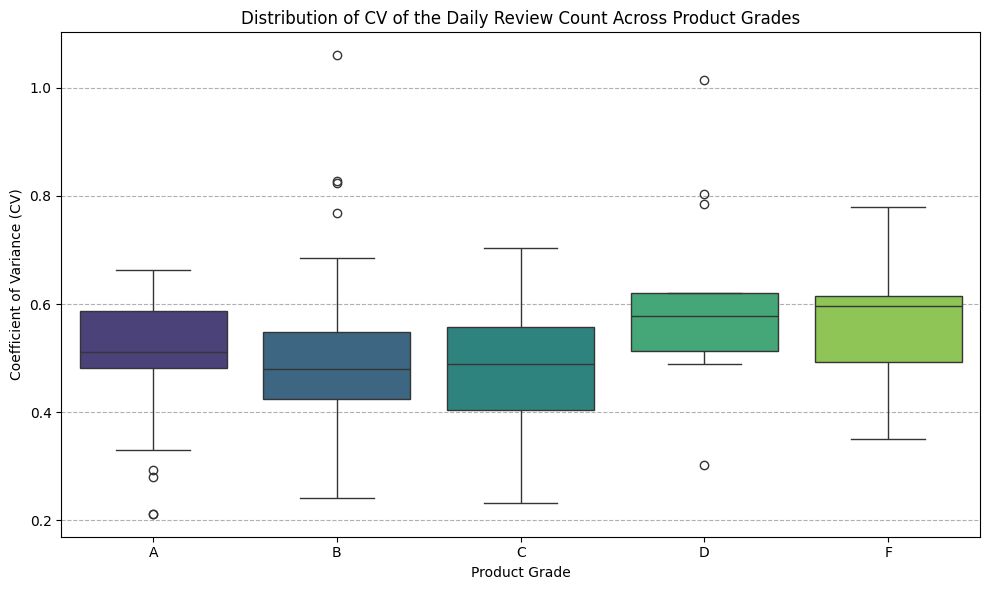

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="cv", data=df_daily_count_stats[df_daily_count_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV of the Daily Review Count Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

Overall - increasing variability with grade generally
- When we move from grade A to F (left to right), the spread of the CV values seems to increase. This means the review counts become more variable day-to-day.
- Products with higher grades (A, B) seem to have more stable, consistent review counts. Products with lower grades (F) demonstrate the highest degree of volatility in daily review counts.


# Suspecious pattern - **number of word count per review**

In [ ]:
df_all_product_features = load_pickle("cache/df_all_product_features")

obj successfully loaded.


Extract the feature_3 which is the word count of each review, and calculate the mean, var, std and cv of the value for each product.

CV represents how variant the sentence lenght it is for the review. The context behind this pattern is that legit reviews from human should be variant. Machine/fake reviews that follows template and standard rules are usually generating similar content.

In [13]:
# feature 3 - word count
review_token_length = df_all_product_features[["feature_3", "product_url"]].groupby("product_url")["feature_3"].apply(list).to_dict()
review_token_length_stats = {}
for product_url, pos_sen  in review_token_length.items():
    review_token_length_stats.setdefault(product_url, {})
    review_token_length_stats[product_url]["mean"] = np.mean(pos_sen)
    review_token_length_stats[product_url]["std"] = np.std(pos_sen)
    review_token_length_stats[product_url]["var"] = np.var(pos_sen)
    review_token_length_stats[product_url]["cv"] = np.std(pos_sen)/np.mean(pos_sen)

In [18]:
df_review_token_length_stats = pd.DataFrame(review_token_length_stats).T
df_review_token_length_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_review_token_length_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/248033536.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="cv", data=df_review_token_length_stats[df_review_token_length_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)


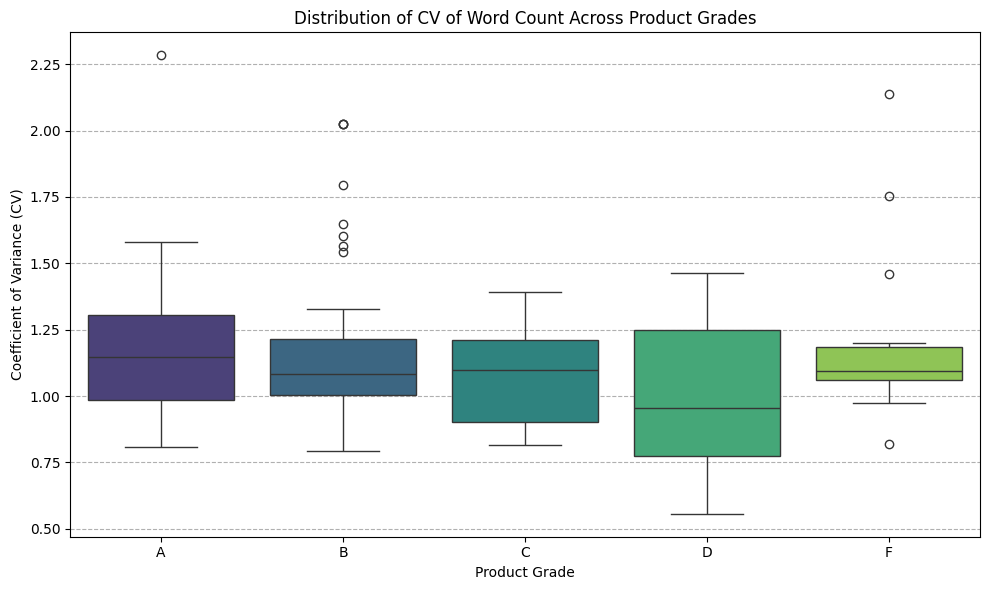

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="cv", data=df_review_token_length_stats[df_review_token_length_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of CV of Word Count Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

There's no obvious trend for all grades from A to F, 
It might suggest that reviews for lower-graded products tend to be more uniform in length, possibly because fake or manipulated reviews might exhibit less variability in length if they're generated using templates or simpler patterns. This is particularly interesting given F represents less reliable reviews.

### Suspecious pattern - **similarity of reviews**

Extract the text token for all reviews from each project, and create TF-IDF features to calcualte the similarity of the reviews for each individual product.

The context behind this analysis is that fake/manipulated reviews which follow same format has higher similarity compared with legit reviews from human that vary based on people's perferences.

In [21]:
product_token_dict = df_all_product_features[["token_string", "product_url"]].groupby("product_url")["token_string"].apply(list).to_dict()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

product_similarity_score = {}
for product_url, review_list in product_token_dict.items():
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(review_list)
    similarity_matrix = cosine_similarity(tfidf_matrix)
        # Extract scores
    scores = []
    for i in range(len(similarity_matrix)):
      for j in range(i + 1, len(similarity_matrix)):
          scores.append(similarity_matrix[i, j])
    scores = np.array(scores)
    if(len(scores) == 0):
        product_scores = {"mean":0, "median":0, "std":0, "scores":[]}
    else:
        product_scores =  {"mean": np.mean(scores), "median": np.median(scores), "std": np.std(scores), "scores": scores}
    product_similarity_score[product_url] = product_scores

In [23]:
df_product_review_similarity_stats = pd.DataFrame(product_similarity_score).T
df_product_review_similarity_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_product_review_similarity_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/2052347128.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="median", data=df_product_review_similarity_stats[df_product_review_similarity_stats["fakespot_grade"].isin(grades)], order=grades, palette="viridis")


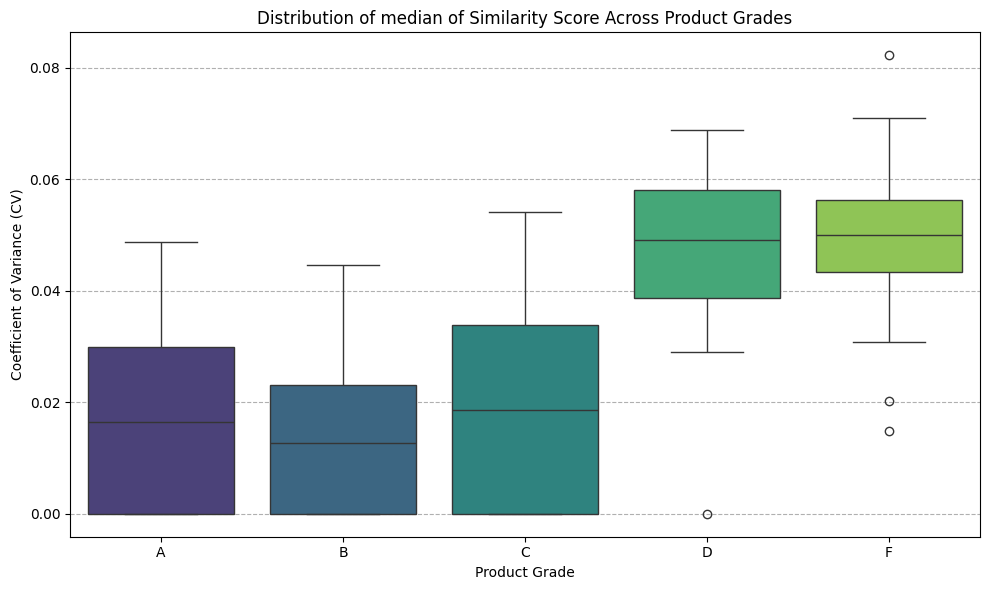

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="median", data=df_product_review_similarity_stats[df_product_review_similarity_stats["fakespot_grade"].isin(grades)], order=grades, palette="viridis")
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of median of Similarity Score Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

The increasing median similarity score and IQR for lower-graded products could indicate more similar/repetitive reviews 

- Fake or bot-generated reviews - These reviews often reuse phrases or templates, leading to higher similarity.
- Review manipulation - Sellers might try to boost ratings by posting multiple similar positive reviews.
- Less diverse customer base - If fewer real customers are reviewing these products, the diversity of opinions and writing styles might be lower, leading to more similar reviews.

# Suspecious pattern - Ratio on number of reviews over number of ratings

For each product, we extracted the total number of ratings and the total number of reviews. 

Context behind is factor is that typically, customers are more inclined to simply rate a product than write a full review. A significantly high ratio of ratings to reviews could be a red flag, suggesting potential manipulation of the product's rating.

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/3300578308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="product_fakespot_grade", y="review_rating_ratio", data=df_all_product_features[(df_all_product_features["review_rating_ratio"]<1)&(df_all_product_features["product_fakespot_grade"].isin(grades))], palette="viridis", order=grades)


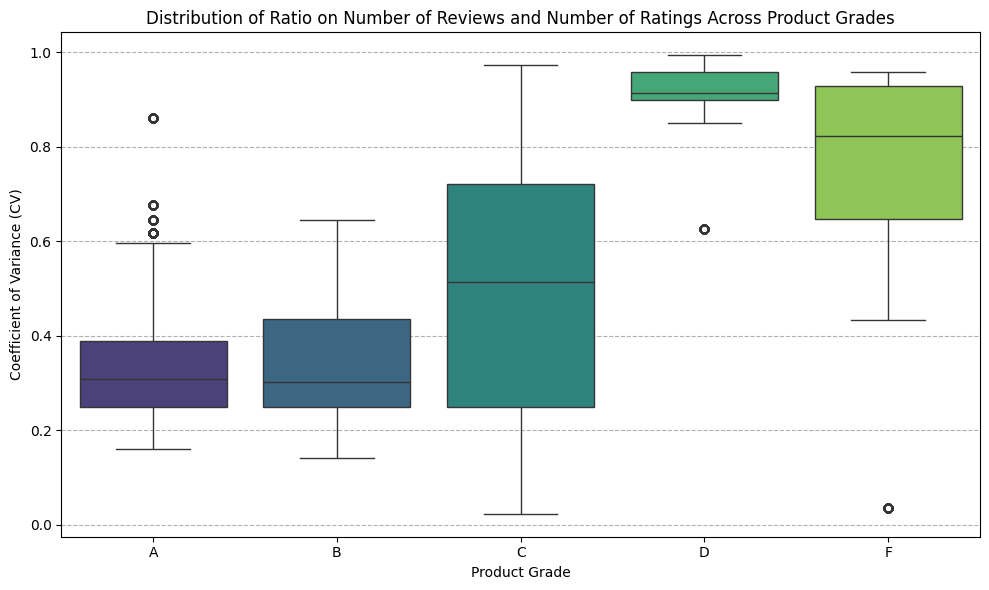

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="product_fakespot_grade", y="review_rating_ratio", data=df_all_product_features[(df_all_product_features["review_rating_ratio"]<1)&(df_all_product_features["product_fakespot_grade"].isin(grades))], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of Ratio on Number of Reviews and Number of Ratings Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

The ratio of ratings to reviews increases as product grades decrease (from A to F).

This is particularly noticeable for grades D and F, where many products exhibit unusually high ratios (e.g., 90+ reviews for every 100 ratings). This pattern contradicts typical consumer behavior, where ratings generally outnumber reviews. The high ratios for lower-graded products raise strong suspicions of review manipulation.

# Suspecious pattern - percentage of number of reviews with image

Similar to above pattern, typical consumer behavior reluctant to add images/videos in their reviews, if the percentage is relatively high then it may indicate suspecious of manipulations.

In [27]:
review_image_count_dict = df_all_product_features.groupby("product_url")["feature_0"].apply("value_counts").to_dict()
review_with_image_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_image_count_dict.items() if url_bool_tuple[1] is True}
review_without_image_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_image_count_dict.items() if url_bool_tuple[1] is False}
df_image_count =pd.DataFrame.from_dict(review_with_image_count_dict, orient="index", columns=["count_review_with_image"])
df_no_image_count =pd.DataFrame.from_dict(review_without_image_count_dict, orient="index", columns=["count_review_without_image"])
df_review_images_count = pd.merge(df_image_count, df_no_image_count, left_index=True, right_index=True)

missing_index = [prod[0] for prod in review_image_count_dict.keys() if prod[0] not in df_review_images_count.index]
df_review_images_count["total_count"] = df_review_images_count["count_review_with_image"] + df_review_images_count["count_review_without_image"]
df_review_images_count["rate_of_review_with_image"] = df_review_images_count["count_review_with_image"]/df_review_images_count["total_count"]
df_review_images_count["fakespot_grade"] = df_review_images_count.index.map(fakespot_grade)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/2214345272.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="rate_of_review_with_image", data=df_review_images_count[df_review_images_count["fakespot_grade"].isin(grades)], palette="viridis", order=grades)


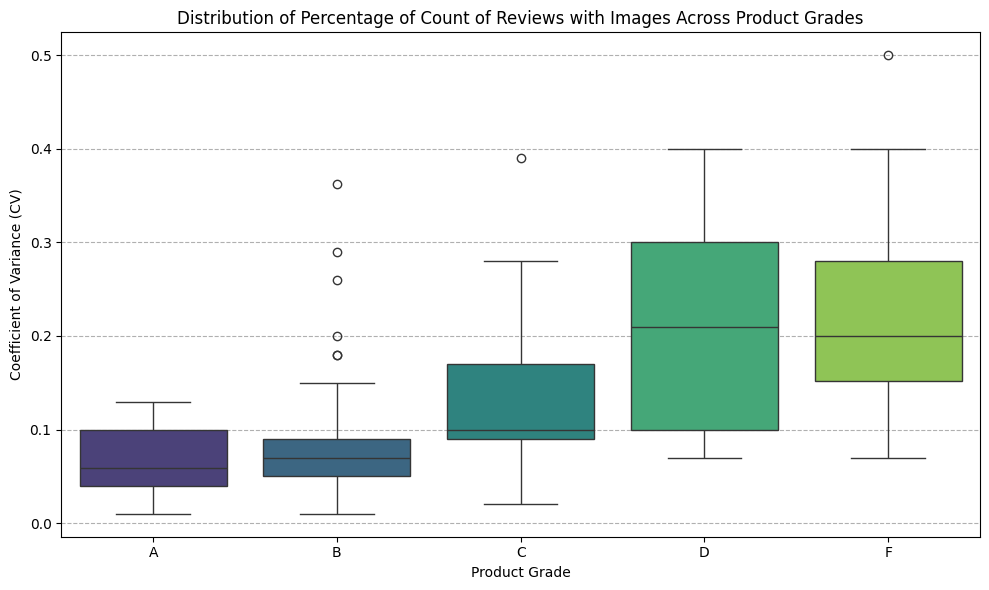

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="rate_of_review_with_image", data=df_review_images_count[df_review_images_count["fakespot_grade"].isin(grades)], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of Percentage of Count of Reviews with Images Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

There's a clear upward trend in the percentage of reviews with images as we move from grade A to grade F. This means products with lower reliability grades tend to have a higher proportion of reviews including images. Fake or incentivized reviews might be more likely to include images to appear more authentic or convincing. This aligns with the expectation that lower-graded products are more susceptible to manipulation.

Grade A has very consistent data with a tight IQR and no outliers.

# Suspecious pattern - percentage of number of reviews with videos

In [30]:
review_video_count_dict = df_all_product_features.groupby("product_url")["feature_1"].apply("value_counts").to_dict()
review_with_video_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_video_count_dict.items() if url_bool_tuple[1] is True}
review_without_video_count_dict = {url_bool_tuple[0]: count for url_bool_tuple, count in review_video_count_dict.items() if url_bool_tuple[1] is False}
df_video_count =pd.DataFrame.from_dict(review_with_video_count_dict, orient="index", columns=["count_review_with_video"])
df_no_video_count =pd.DataFrame.from_dict(review_without_video_count_dict, orient="index", columns=["count_review_without_video"])
df_review_video_count = pd.merge(df_video_count, df_no_video_count, left_index=True, right_index=True)

missing_index = [prod[0] for prod in review_video_count_dict.keys() if prod[0] not in df_review_video_count.index]
df_review_video_count["total_count"] = df_review_video_count["count_review_with_video"] + df_review_video_count["count_review_without_video"]
df_review_video_count["rate_of_review_with_video"] = df_review_video_count["count_review_with_video"]/df_review_video_count["total_count"]
df_review_video_count["fakespot_grade"] = df_review_video_count.index.map(fakespot_grade)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/1254666554.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="rate_of_review_with_video", data=df_review_video_count[df_review_video_count["fakespot_grade"].isin(grades)], palette="viridis", order=grades)


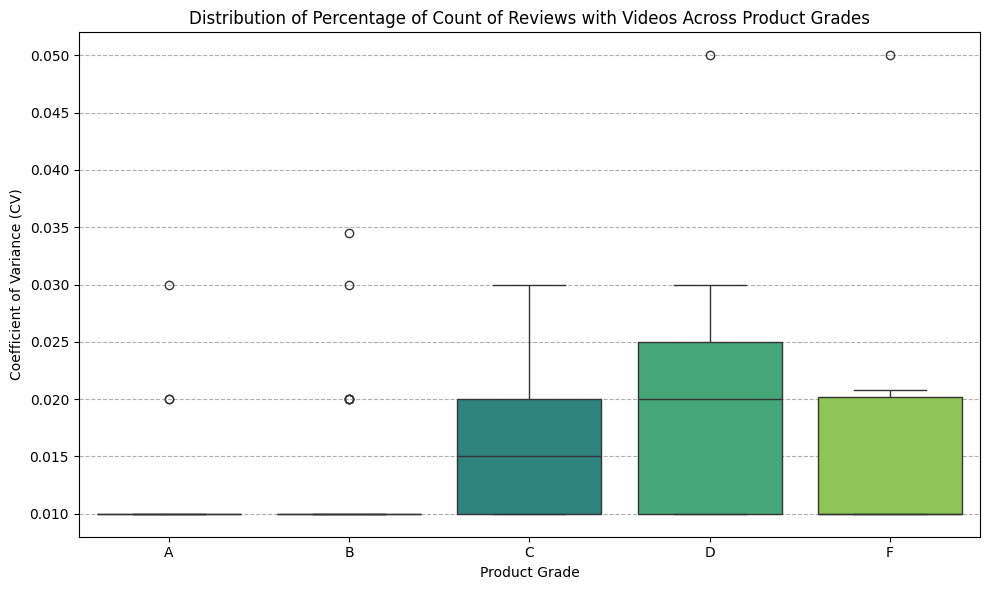

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="rate_of_review_with_video", data=df_review_video_count[df_review_video_count["fakespot_grade"].isin(grades)], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of Percentage of Count of Reviews with Videos Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

The low overall percentages likely reflect the greater effort required to create and upload video reviews compared to text or image reviews, the percentage of reviews with videos is generally quite low across all grades, with most medians falling below 0.025 (2.5%).

While the percentages are low, there's a general upward trend from grade A to D. However, grade F shows a decrease in the median percentage compared to D.

### Suspecrious pattern - **review sentiment**

Fake or manipulated reviews has one objective, is to convience the potential customers that the product is good. So unless the project is absolutely satisfied for everyone, the sentiment should has mix of positive and negative reviews.

In [ ]:
# feature 6 is the popularity score of postivie sentiment
review_pos_sentiment = df_all_product_features[["feature_6", "product_url"]].groupby("product_url")["feature_6"].apply(list).to_dict()
review_pos_sentiment_stats = {}
for product_url, pos_sen  in review_pos_sentiment.items():
    review_pos_sentiment_stats.setdefault(product_url, {})
    review_pos_sentiment_stats[product_url]["mean"] = np.mean(pos_sen)
    review_pos_sentiment_stats[product_url]["std"] = np.std(pos_sen)
    review_pos_sentiment_stats[product_url]["var"] = np.var(pos_sen)
    review_pos_sentiment_stats[product_url]["cd"] = np.std(pos_sen)/np.mean(pos_sen)

In [34]:
df_review_pos_sentiment_stats = pd.DataFrame(review_pos_sentiment_stats).T
df_review_pos_sentiment_stats["fakespot_grade"] = [fakespot_grade[product_url] for product_url in df_review_pos_sentiment_stats.index]

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_96992/1352904350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fakespot_grade", y="mean", data=df_review_pos_sentiment_stats[df_review_pos_sentiment_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)


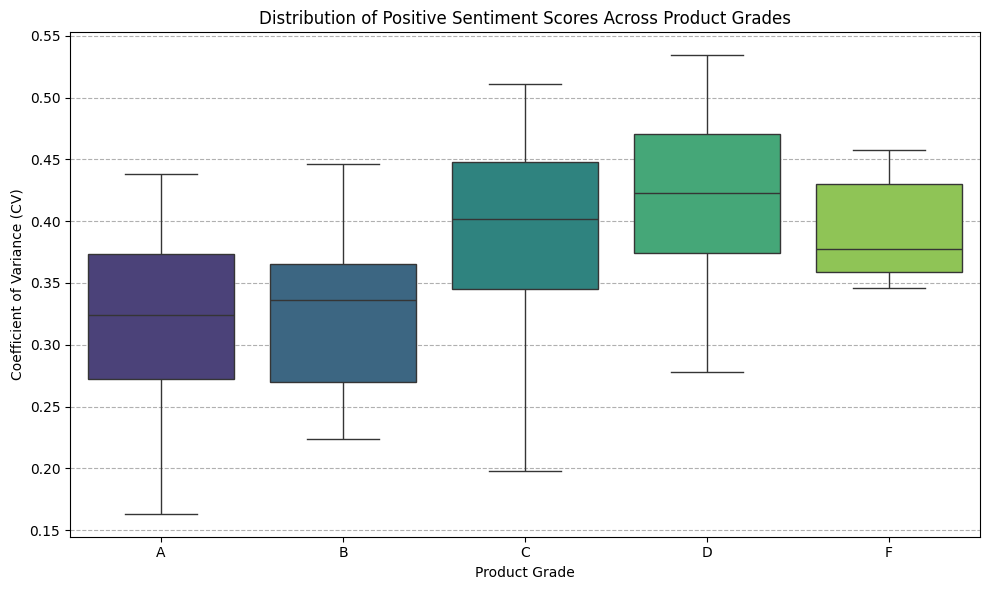

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="fakespot_grade", y="mean", data=df_review_pos_sentiment_stats[df_review_pos_sentiment_stats["fakespot_grade"].isin(grades)], palette="viridis", order=grades)
plt.xlabel("Product Grade")
plt.ylabel("Coefficient of Variance (CV)")
plt.title("Distribution of Positive Sentiment Scores Across Product Grades")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

There's a general upward trend in positive sentiment scores as we move from product grade A to D. This suggests that lower-graded products tend to have higher positive sentiment in their reviews.

# Experimental modelling - classification

Building a binary classification model to classify if a the review is legit (not fake). 

Assumption:
- Assume all the reviews in grade F are fake, and all the reviews in grade A are legit
- Train a classifier to classify on every grade
- Based on percentage of classified A & F, and define a list of threshold/range, we can define or give a grade to each product based on the reviews

Data preprocessing:
- text preprocessing
- tokenization
- generate basic nlp features for reviews
- calculate product level features discussed above, reviews on same product shares the same values

Train test split:
- reviews by same product are treated as unsplitable data group, so the train test split is split by product url
- all reviews from a product should be either in the training set, or testing set

models:
- Basic benchmark model - random forest
- XGBoost Classifier

In [39]:
df_all_product_features = load_pickle("cache/df_all_product_features")

obj successfully loaded.


In [40]:
# percentage of num. reviews with image
review_with_image_counts = df_all_product_features.groupby("product_url")["feature_0"].sum().to_dict()
review_counts = df_all_product_features.groupby("product_url")["feature_0"].count().to_dict()
review_with_image_percentage = {}
for product_url, count in review_counts.items():
    review_with_image_percentage[product_url] = review_with_image_counts.get(product_url, 0)/ review_counts[product_url] 

In [41]:
# percentage of num. reviews with image
review_with_video_counts = df_all_product_features.groupby("product_url")["feature_1"].sum().to_dict()
review_with_video_percentage = {}
for product_url, count in review_counts.items():
    review_with_video_percentage[product_url] = review_with_video_counts.get(product_url, 0)/ review_counts[product_url] 

In [42]:
# coefficient of variance for daily number of reviews (how fluctuated on the daily review count)
cv_daily_review_count = {product_url: d["cv"] for product_url, d in product_daily_count_stats.items()}

In [43]:
# coefficient of variance for number of token of reviews (how fluctuated on the length of the review)
cv_review_token_length = {product_url: d["cv"] for product_url, d in review_token_length_stats.items()}

In [44]:
# similarity of the reviews
product_similarity_score_mean = {product_url: d["mean"] for product_url, d in product_similarity_score.items()}
product_similarity_score_median = {product_url: d["median"] for product_url, d in product_similarity_score.items()}

In [45]:
df_all_product_features["review_with_image_percentage"] = df_all_product_features["product_url"].map(review_with_image_percentage)
df_all_product_features["review_with_video_percentage"] = df_all_product_features["product_url"].map(review_with_video_percentage)
df_all_product_features["cv_daily_review_count"] = df_all_product_features["product_url"].map(cv_daily_review_count)
df_all_product_features["cv_review_token_length"] = df_all_product_features["product_url"].map(cv_review_token_length)
df_all_product_features["product_similarity_score_mean"] = df_all_product_features["product_url"].map(product_similarity_score_mean)
df_all_product_features["product_similarity_score_median"] = df_all_product_features["product_url"].map(product_similarity_score_median)


In [47]:
df_all_product_features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,token_string,product_url,review_rating_ratio,product_fakespot_grade,review_with_image_percentage,review_with_video_percentage,cv_daily_review_count,cv_review_token_length,product_similarity_score_mean,product_similarity_score_median
R30SZV56T07JOV,False,False,4,9,6.111111,7,0.577,0.0,0.423,0.8012,quality sound really good good quality materia...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B,0.06,0.0,0.451664,1.544582,0.03372,0.009828
R2YD8IZAN1L5QV,False,False,1,20,4.5,17,0.0,0.217,0.783,-0.6124,difficult pair pair alexa never got work even ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B,0.06,0.0,0.451664,1.544582,0.03372,0.009828
R1SG3KLESASNYO,False,False,4,4,5.5,4,0.516,0.0,0.484,0.4927,price product really good,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B,0.06,0.0,0.451664,1.544582,0.03372,0.009828
R1BRUHA6158TD1,False,False,1,14,5.357143,14,0.326,0.163,0.512,0.5423,product performs 20 ear bud design great idea ...,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B,0.06,0.0,0.451664,1.544582,0.03372,0.009828
R3IK00EI1WUVQO,False,False,4,7,5.714286,7,0.406,0.0,0.594,0.6249,great battery life connection volume 100 phone,https://www.amazon.com/All-new-Echo-Buds-2023-...,0.317468,B,0.06,0.0,0.451664,1.544582,0.03372,0.009828


In [48]:
feature_cols = [col for col in df_all_product_features.columns if col not in ["product_fakespot_grade", "token_string", "product_url"]]

In [423]:
# train test split

In [39]:
# get only A & F products from the df
df_model_data = df_all_product_features[df_all_product_features["product_fakespot_grade"].isin(["A", "F"])]

In [ ]:
df_model_data["product_fakespot_grade"] = df_model_data["product_fakespot_grade"].replace("A", 1)
df_model_data["product_fakespot_grade"] = df_model_data["product_fakespot_grade"].replace("F", 0)
product_grade_df = df_model_data[["product_url", "product_fakespot_grade"]].drop_duplicates()

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(product_grade_df["product_url"], product_grade_df["product_fakespot_grade"], test_size=0.3, random_state=42)

In [44]:
y_train, y_test = df_model_data[df_model_data["product_url"].isin(X_train.values)]["product_fakespot_grade"].values, df_model_data[df_model_data["product_url"].isin(X_test.values)]["product_fakespot_grade"].values

In [45]:
df_model_data = df_model_data.replace(True, 1)
df_model_data = df_model_data.replace(False, 0)

/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3457774219.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model_data = df_model_data.replace(True, 1)
/var/folders/l5/7tf27m_n63l32m8869jhz85m0000gr/T/ipykernel_74512/3457774219.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model_data = df_model_data.replace(False, 0)


In [46]:
X_train_with_features, X_test_with_features = df_model_data[df_model_data["product_url"].isin(X_train.values)][feature_cols].values, df_model_data[df_model_data["product_url"].isin(X_test.values)][feature_cols].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler()
X_train_features_scaled = scaler.fit_transform(X_train_with_features)
X_test_features_scaled = scaler.transform(X_test_with_features)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_model_data[df_model_data["product_url"].isin(X_train.values)]["token_string"].values)
X_test_vec = vectorizer.transform(df_model_data[df_model_data["product_url"].isin(X_test.values)]["token_string"].values)

X_train_all_features = np.concatenate((X_train_features_scaled, X_train_vec.toarray()), axis=1)
X_test_all_features = np.concatenate((X_test_features_scaled, X_test_vec.toarray()), axis=1)

In [120]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)  # Reduce to, say, 100 dimensions
X_train_reduced_features = svd.fit_transform(X_train_all_features)
X_test_reduced_features = svd.transform(X_test_all_features)

In [121]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
oversampler = SMOTE(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X_train_reduced_features, y_train)

In [122]:
# benchmark model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


model = RandomForestClassifier(random_state=42, class_weight='balanced') 

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
# Parameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

# Get best model and its best parameters
model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [123]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_reduced_features)
print("\nEvaluation Metrics:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       417
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      1717
   macro avg       0.97      0.96      0.97      1717
weighted avg       0.98      0.98      0.98      1717

Accuracy: 0.9761211415259173


In [55]:
# test on other products

In [136]:
grades = ["A", "B", "C", "D","F"]

In [151]:
for grade in grades:
    df_b = df_all_product_features[(df_all_product_features["product_fakespot_grade"].isin([grade])) & (~df_all_product_features["product_url"].isin(X_train.values))]
    df_b = df_b.replace({True: 1, False: 0}).infer_objects(copy=False)

    X_test_b = df_b[feature_cols].values
    X_test_b_features_scaled = scaler.transform(X_test_b)
    X_test_b_vec = vectorizer.transform(df_b["token_string"].values)
    X_test_b_all_features = np.concatenate((X_test_b_features_scaled, X_test_b_vec.toarray()), axis=1)
    X_test_b_reduced_features = svd.transform(X_test_b_all_features)

    y_b_pred = model.predict(X_test_b_reduced_features)
    F_rate = list(y_b_pred).count(1)/len(y_b_pred)
    print(f"grade {grade}, rate {F_rate}")

grade A, rate 0.9907692307692307
grade B, rate 0.954853034468175
grade C, rate 0.788829005389515
grade D, rate 0.23615384615384616
grade F, rate 0.06954436450839328


Based on the above result, the model can classified the review by either legit or not, and by calculating how many percent of the reviews for a product is legit, and defining a proper thresholds, we can assign grade to each product

example:
- A: `>= 0.97`
- B: `< 0.97 & >= 0.8`
- C: `< 0.8 & >= 0.3`
- D: `< 0.3 & >=0.1`
- F: `< 0.1`

Call-outs:

- This is a supervised learning model, which means we will need enough label data points to train the model
- The label needs to be accurate enough for the model to learn the actual pattern, which is a big challenge as the legitment of the review is hard to identify with 100% confidency
- Threshold definition is going to be a challenging task, as for now they are defined by heuristic rules

# Appendix on explorations

Explored the unsupervised learning and didn't reach to promising results

Tried visualized in 2d on if clusterings exists by categories, didn't observed obvious clustering on different grades of reviews

In [ ]:
# unsupervised
df_unsupervised = df_all_product_features[df_all_product_features["product_fakespot_grade"]!="?"][["product_url", "product_fakespot_grade"]].drop_duplicates()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_unsupervised["product_url"], df_unsupervised["product_fakespot_grade"], test_size=0.3, random_state=42)
y_train_unsupervised, y_test_unsupervised = df_all_product_features[df_all_product_features["product_url"].isin(X_train.values)]["product_fakespot_grade"].values, df_all_product_features[df_all_product_features["product_url"].isin(X_test.values)]["product_fakespot_grade"].values
X_train_features_unsupervised, X_test_features_unsupervised = df_all_product_features[df_all_product_features["product_url"].isin(X_train.values)][feature_cols].values, df_all_product_features[df_all_product_features["product_url"].isin(X_test.values)][feature_cols].values

In [130]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features_unsupervised)
X_test_features_scaled = scaler.transform(X_test_features_unsupervised)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_all_product_features[df_all_product_features["product_url"].isin(X_train.values)]["token_string"].values)
X_test_vec = vectorizer.transform(df_all_product_features[df_all_product_features["product_url"].isin(X_test.values)]["token_string"].values)


In [142]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)  # Reduce to, say, 100 dimensions
X_train_reduced_features = svd.fit_transform(X_train_vec.toarray())
X_test_reduced_features = svd.transform(X_test_vec.toarray())

X_train_all_features = np.concatenate((X_train_features_scaled, X_train_features_scaled), axis=1)
X_test_all_features = np.concatenate((X_test_features_scaled, X_test_features_scaled), axis=1)

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# Train MiniBatchKMeans 
kmeans = MiniBatchKMeans(n_clusters=2, init='k-means++', random_state=42, batch_size=1000)  # Adjust batch_size
kmeans.fit(X_train_all_features)
labels = kmeans.labels_
df_eval = pd.DataFrame(y_train_unsupervised, columns=["target"])

In [ ]:
df_eval["model_label"] = labels
for label in df_eval["model_label"].unique():
    print(df_eval[df_eval["model_label"]==label]["target"].value_counts())

In [163]:
from nltk.util import ngrams
from collections import Counter

def analyze_ngrams(tokens, n):
    n_grams = ngrams(tokens, n)
    n_gram_counts = Counter(n_grams)
    return n_gram_counts

grades = ["A", "B", "C", "D", "F"]
ngram_data = {}
n = 2
for grade in ["A", "B", "C", "D", "F"]:
    reviews_grade_dict = df_all_product_features[df_all_product_features["product_fakespot_grade"]==grade]["token_string"].to_dict()
    all_ngram_counts = Counter()
    for review in reviews_grade_dict.values():
        tokens = review.split(" ")
        ngram_counts = analyze_ngrams(tokens, n)
        all_ngram_counts.update(ngram_counts)

    print(f"Top {n}-grams across all reviews:")
    for ngram, count in all_ngram_counts.most_common(10):
        print(f"grade {grade} {ngram}: {count}")
    ngram_data[grade] = all_ngram_counts


Top 2-grams across all reviews:
grade A ('sound', 'quality'): 369
grade A ('battery', 'life'): 296
grade A ('ear', 'bud'): 125
grade A ('great', 'sound'): 120
grade A ('sound', 'great'): 108
grade A ('work', 'great'): 100
grade A ('good', 'sound'): 98
grade A ('noise', 'canceling'): 93
grade A ('stopped', 'working'): 93
grade A ('noise', 'cancellation'): 91
Top 2-grams across all reviews:
grade B ('sound', 'quality'): 966
grade B ('battery', 'life'): 579
grade B ('ear', 'bud'): 302
grade B ('great', 'sound'): 282
grade B ('noise', 'cancelling'): 280
grade B ('sound', 'great'): 255
grade B ('noise', 'canceling'): 221
grade B ('good', 'sound'): 217
grade B ('noise', 'cancellation'): 197
grade B ('stopped', 'working'): 190
Top 2-grams across all reviews:
grade C ('sound', 'quality'): 314
grade C ('battery', 'life'): 197
grade C ('ear', 'bud'): 99
grade C ('great', 'sound'): 90
grade C ('noise', 'cancelling'): 83
grade C ('easy', 'use'): 68
grade C ('sound', 'great'): 68
grade C ('good', '